<div style="width:90%; margin:0 auto; background-color:#F0F0F0; padding:20px; border-radius:8px; font-family:Arial, sans-serif">

<div style="display:flex; align-items:center; justify-content:space-between; margin-bottom:15px">
    <div style="width:100px; height:100px">
        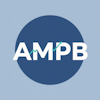
    </div>
    <div style="text-align:center; margin-bottom:20px">
        <h1 style="color:#9E0B0F; font-size:26px; margin-bottom:5px">Análisis de modelos predictivos en bolsa</h1>
        <h3 style="color:#D64550; font-size:22px; margin-top:0">Copyright (C) 2024-2025 MegaStorm Systems</h3>
    </div>
    <div style="width:192px; height:59px">
        <p style="max-width:100%; max-height:100%">
    </div>
</div>

<div style="width:60%; margin:0 auto; background-color:#E8E8E8; padding:20px; border-radius:10px; border:1px solid #D0D0D0; margin-bottom:20px; color:#333333; line-height:1.5; box-shadow:0 2px 4px rgba(0,0,0,0.05)">
    <p style="margin:0; font-size:15px">    
    This software is provided "as-is", without any express or implied<br>
    warranty. In no event will the authors be held liable for any damages<br>
    arising from the use of this software.<br><br>
    Permission is granted to anyone to use this software for any purpose,<br>
    including commercial applications, and to alter it and redistribute it<br>
    freely, subject to the following restrictions:<br><br>
    1. The origin of this software must not be misrepresented; you must not<br>
    claim that you wrote the original software. If you use this software<br>
    in a product, an acknowledgment in the product documentation would be<br>
    appreciated but is not required.<br>
    2. Altered source versions must be plainly marked as such, and must not be<br>
    misrepresented as being the original software.<br>
    3. This notice may not be removed or altered from any source distribution.
    </p>
</div>

<div style="text-align:center">
    <h2 style="font-size:24px; color:#9E0B0F; margin:0">Predictor ARIMA v2.3</h2>
</div>

</div>

In [ ]:
# Importar librerías
import os
import argparse
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import pandas as pd
import numpy as np
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import model_selection
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
import time
import warnings

warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=ValueWarning)

from ampblib import AMPBConfig, processData, generateEvaluation, createReport, reverseTransformPredictions, createModelIdentity

In [ ]:
# 0. PARÁMETROS CONFIGURABLES

model_name = "ARIMA"
model_version = "v2.3"

# Por defecto, permite ejecucion interactiva
default_transformation = "RetLog" # "None", "Log", "RetLog", "YeoJohnson"

# Estos son fijos e internos, no los exponemos
nombre_archivo = "NVDA_2015-01-05_2025-05-23_SA.csv"
test_size = 60              # Número de días para el conjunto de test
optimize_orders = True     # True para optimizar (p,d,q) con auto_arima, False para usar valores fijos
fixed_order = (2,0,0)       # Orden (p,d,q) si optimizar = False. Mejores valores identificados: None(3,1,2) - Log(1,1,0) - RetLog(2,0,0) - YeoJohnson (1,1,0)                             
run_backtesting = True     # True para Backtesting con Walk-Forward y False para no realizar este test (utiliza orders optimizados anteriores o fijos)
retrain_interval = 1        # Reentrenar modelo completo cada n días en backtesting. 5 es un valor adecuado, acelera la velocidad a cambio de perder un ~6% de rendimiento.

# Argumentos de línea de comandos  
if AMPBConfig.INTERACTIVE:
    transformation = default_transformation
else:
    parser = argparse.ArgumentParser(description='Ejecuta modelo ARIMA.')
    parser.add_argument('--transformation', type=str, default=default_transformation, choices=['None', 'Log', 'RetLog', 'YeoJohnson'])
    args = parser.parse_args()
    transformation = args.transformation

AMPBConfig.printHeader(title=f"Predictor {model_name} {model_version}", testsize=test_size, 
                     optimize=optimize_orders, backtesting=run_backtesting, transform=transformation,
                     exogscaling="None", exogsetid=0)

In [ ]:
# 1. CARGA Y PREPARACIÓN DE DATOS
datos = pd.read_csv(nombre_archivo)

# Seleccionar columnas relevantes
mandatory_vars = ['Date','Close', 'Trend']

df = datos[mandatory_vars]

# Convertir fechas a datetime
df['Date'] = pd.to_datetime(df['Date'])  

# Verificar y mostrar estadísticas básicas de los datos
print(f"Datos en crudo cargados: {len(df)} registros de {df['Date'].min()} a {df['Date'].max()}.")

# Detectar valores faltantes
missing = df.isna().sum()
missing = missing[missing > 0]

if not missing.empty:
    total_before = len(df)
    print("Valores faltantes por columna (se borrarán estas filas):")
    for col, cnt in missing.items():
        print(f"  • {col}: {cnt} valores faltantes")
    df = df.dropna().reset_index(drop=True)
    total_after = len(df)
    removed = total_before - total_after
    print(f"\nFilas borradas: {removed}")
else:
    print("No se encontraron valores faltantes.")

# Poner Date como indice
df.set_index('Date', inplace=True)
#df = df.asfreq('B', method='pad')  # Se asume que se trata de datos bursátiles (días hábiles) y rellena con valores previos

print(f"\nDatos cargados: {AMPBConfig.COLOR_VALUE}{len(df)}{AMPBConfig.COLOR_RESET} registros. ARIMA no utiliza variables exógenas.") 


In [ ]:
# 2. DIVISIÓN ENTRE ENTRENAMIENTO Y TEST

# 2A. Se utiliza el 90% de los datos para entrenamiento y el 10% para test
#split_index = int(len(df) * 0.90)
#df_train = df.iloc[:split_index].copy()
#df_test = df.iloc[split_index:].copy()

# 2B. Separamos datos de entrenamiento y de test por fecha
#split_date = pd.Timestamp('2024-12-01')
#df_train = df.loc[:split_date].copy()
#df_test = df.loc[split_date:].copy()

# 2C. Separamos por numero de dias.
df_train = df.iloc[:-test_size]
df_test = df.iloc[-test_size:]

# Guardar valores originales (inmutables para referencia futura)
y_train_original = df_train['Close'].copy()
y_test_original = df_test['Close'].copy()

# Variables de trabajo (se transformarán/escalarán según configuración)
y_train = df_train['Close']
y_test  = df_test['Close']

print(f"\nDatos divididos:")
print(f"  Entrenamiento: {AMPBConfig.COLOR_VALUE}{len(y_train)}{AMPBConfig.COLOR_RESET} filas (hasta {y_train.index[-1].date()})")
print(f"  Test:          {AMPBConfig.COLOR_VALUE}{len(y_test)}{AMPBConfig.COLOR_RESET} filas (desde {y_test.index[0].date()})")

In [ ]:
# 3. PROCESAR DATOS: TRANSFORMACIONES, ESCALADO, ALINEACION Y ANALISIS DE CALIDAD
# Bajo determinadas circunstancias, puede abortar la ejecucion.
processing_results = processData(
    y_train, y_test, None, None,
    y_train_original, y_test_original, None, None,
    df_test, None, transformation, None,
    winsorization_value=0,   
    analyze=False               # Sin exógenas, no hay nada que analizar
)
params_close = processing_results['params_close']
y_scaler = processing_results['y_scaler']
df_test_aligned = processing_results['df_test_aligned']
prediction_max_limit = processing_results['prediction_max_limit']

In [ ]:
# 4. ENCONTRAR ORDENES OPTIMOS CON AUTO_ARIMA (SOLO EN TRAIN DATA)

# Variables para almacenar el mejor modelo
best_model = None
best_order = None

# 4A. OPTIMIZACIÓN DEL MODELO ARIMA CON AUTO_ARIMA
if optimize_orders:
    print("Buscando el mejor orden para ARIMA...")

    auto_model = pm.auto_arima(y_train,
                               method='lbfgs',      # Usamos el metodo por defecto y compatible con ARIMA
                               start_p=0, max_p=3,  # Rango para p
                               start_d=0, max_d=1,  # Rango para d  
                               start_q=0, max_q=3,  # Rango para q
                               m=1,                 # Frecuencia de la serie (1 para no estacional)
                               seasonal=False,      # Buscar solo modelos ARIMA (no SARIMA)
                               stepwise=False,      # No usamos búsqueda stepwise (es más lento)
                               suppress_warnings=True, # Suprimir warnings de convergencia, etc.
                               error_action='ignore', # Ignorar órdenes que fallen
                               trace=False, 
                               information_criterion='aic' # Criterio para seleccionar el mejor modelo. 'bic' 'aic'
                              )

    # Extraer los órdenes óptimos del modelo auto_arima
    best_order = auto_model.order
    print(f"Auto-ARIMA encontró orden óptimo: {best_order}")

# 4B. USAR OPTIMIZACION PREVIA
else:   
    # Usar p,d,q optimos
    best_order = fixed_order
    print(f"Utilizando orden fijo: {best_order}")

# 4C. AJUSTE DE ARIMA 
print("Ajustando modelo...")
model = ARIMA(y_train, order=best_order)
best_model = model.fit()  # ARIMA por defecto tambien utiliza lbfgs
    
# Creamos el título (y su hash) y mostramos resultados
model_title, model_hash = createModelIdentity(model_name, model_version, f"{best_order}", transformation, "None", "None")
print(f"\n{AMPBConfig.COLOR_INFO}Parametros para {model_name}{model_version}:{AMPBConfig.COLOR_RESET}")
print(f" Order (p,d,q): {best_order}")
print(f"\nTítulo: '{model_title}' con HashID: {model_hash}\n")

In [ ]:
# 5A. PREDICCIÓN Y EVALUACIÓN EN EL CONJUNTO DE TEST (VALIDACIÓN ESTÁTICA)
print(f"{AMPBConfig.COLOR_INFO}Validación Estática{AMPBConfig.COLOR_RESET}")

# Predicción del período de test completo
forecast_scaled_transformed = best_model.get_forecast(steps=len(y_test)).predicted_mean
forecast_scaled_transformed.index = y_test.index

# Aplicar pipeline de des-transformación
forecast_original = reverseTransformPredictions(
    forecast_scaled_transformed,
    y_train_original.iloc[-1],
    y_scaler,
    transformation, 
    params_close,
    prediction_max_limit
)

# Predicción día siguiente
next_day_date = y_test.index[-1] + pd.tseries.offsets.BDay(1)
next_forecast_scaled_transformed = best_model.get_forecast(steps=1).predicted_mean

next_day_forecast_original = reverseTransformPredictions(
    next_forecast_scaled_transformed, 
    y_test_original.iloc[-1], # Para la referencia del día siguiente, usar el último valor real del test
    y_scaler,
    transformation,
    params_close,
    prediction_max_limit
).iloc[0]

In [ ]:
# 5B. EVALUACIÓN Y GRÁFICAS
# Evaluación de validación estática
sv_r2, sv_mae, sv_rmse, sv_accuracy, sv_f1_score, sv_roc_auc = generateEvaluation(
    y_test_original, forecast_original, df_test_aligned, model_title, model_hash, 
    next_day_date, next_day_forecast_original, "Static Validation")

# Guardar reporte
createReport(model_name, "SV", f"{transformation}", 
             model_title, model_hash, sv_r2, sv_mae, sv_rmse, sv_accuracy, sv_f1_score, sv_roc_auc)

In [ ]:
# 6. EVALUACIÓN CON CROSS VALIDATION (VALIDACIÓN CRUZADA)
# Opcional, no disponible en este modelo.

In [ ]:
# 7A. MODO DE BACKTESTING: PREDICCIÓN DÍA A DÍA (VALIDACIÓN BACKTESTING)
if run_backtesting:    
    model_title_backtest = f'{model_title} (Backtesting [{retrain_interval}d])'
    print(f"\n{AMPBConfig.COLOR_INFO}Modo Backtesting con Walk-Forward (Retrain cada {retrain_interval} días){AMPBConfig.COLOR_RESET}")
    
    # Inicializar historiales (solo serie temporal, sin exógenas)
    history_y = y_train.copy()              # Datos transformados/escalados para el modelo
    history_y_original = y_train_original.copy()  # Valores originales para referencias
    
    predictions_original_bt = []
    model_bt = None  # Modelo que se reutilizará entre reentrenamientos
    
    bt_start = time.time()
    for t in range(len(y_test)):
        print(f" Backtesting: {t+1}/{len(y_test)}", end='')
        
        # Reentrenar el modelo cuando sea necesario
        if t % retrain_interval == 0:   
            print(f" [Reentrenando...]", end='')
            model_bt = ARIMA(history_y, order=best_order).fit()
            print(f" [✓]", end='')
        
        print(f"")
        
        # Predecir 1 paso adelante (ARIMA sin exógenas)
        forecast_step_scaled_transformed = model_bt.get_forecast(steps=1).predicted_mean
        
        # Des-transformar usando pipeline centralizado 
        reference_val = history_y_original.iloc[-1]
        forecast_step_original = reverseTransformPredictions(
            forecast_step_scaled_transformed,
            reference_val,
            y_scaler,
            transformation,
            params_close,
            prediction_max_limit
        ).iloc[0]
                
        # Guardar predicción
        predictions_original_bt.append(forecast_step_original)
        
        # Actualizar historiales con datos reales del día t (solo serie temporal)
        history_y = pd.concat([history_y, y_test.iloc[t:t+1]])
        history_y_original = pd.concat([history_y_original, pd.Series([y_test_original.iloc[t]], index=[y_test_original.index[t]])])
    
    # Estadísticas de reentrenamiento
    total_retrains = (len(y_test) + retrain_interval - 1) // retrain_interval  
    print(f" Backtesting completado en {time.time() - bt_start:.1f}s")
    print(f" Reentrenamientos realizados: {total_retrains} (cada {retrain_interval} días)\n")
    
    # Crear Serie con predicciones del backtesting
    forecast_backtest_original = pd.Series(predictions_original_bt, index=y_test_original.index)

In [ ]:
 # 7B. MODO DE BACKTESTING: PREDICCIÓN SIGUIENTE DÍA
if run_backtesting:
    # Predecir y des-transformar usando pipeline centralizado (ARIMA sin exógenas)
    next_forecast_scaled_transformed_bt = model_bt.get_forecast(steps=1).predicted_mean
    next_day_forecast_val_bt_original = reverseTransformPredictions(
        next_forecast_scaled_transformed_bt, 
        history_y_original.iloc[-1], # Predicción para el día siguiente usando el último modelo del backtesting
        y_scaler, 
        transformation, 
        params_close,
        prediction_max_limit
    ).iloc[0]
    
    print(f"  Predicción BT para {next_day_date.strftime('%Y-%m-%d')}: {AMPBConfig.COLOR_VALUE}{next_day_forecast_val_bt_original:.2f}{AMPBConfig.COLOR_RESET}")

In [ ]:
# 7C. MODO DE BACKTESTING: EVALUACIÓN Y GRÁFICAS  
if run_backtesting:
    # Evaluación del backtesting
    bt_r2, bt_mae, bt_rmse, bt_accuracy, bt_f1_score, bt_roc_auc = generateEvaluation(
        y_test_original, 
        forecast_backtest_original, 
        df_test_aligned, 
        model_title_backtest, 
        model_hash,
        next_day_date, 
        next_day_forecast_val_bt_original, 
        "Backtesting"
    )

    # Guardar informe del backtesting
    createReport(model_name, "BT", f"{transformation}", 
                 model_title, model_hash, bt_r2, bt_mae, bt_rmse, bt_accuracy, bt_f1_score, bt_roc_auc)

In [ ]:
# OPCIONAL 1: IMPLEMENTACIÓN MÉTODO SIGMOIDE DE LA DIFERENCIA (para pseudo-probabilidades)
'''
# Calcular la diferencia de precios PREDICHOS. Usamos forecast_series que ya tiene el índice correcto
arima_diff_score = forecast_series.diff() # Diferencia entre predicciones consecutivas
# Calcular la diferencia de precios PREDICHOS
arima_diff_score = forecast_series.diff()
# Eliminar el primer valor (NaN)
arima_diff_score = arima_diff_score.iloc[1:]

# Calcular el factor de escala 'k' base
if transform and transform != "None" and 'Close_original' in df_train.columns:
    train_price_diff_std = df_train['Close_original'].diff().std()
else:
    train_price_diff_std = df_train['Close'].diff().std()
k_base = 1.0 / train_price_diff_std if train_price_diff_std > 1e-6 else 1.0
k_multiplier = 20.0 
k_scaling_factor = k_base * k_multiplier

# Aplicar la función sigmoide con el k ajustado
epsilon = 1e-9
arima_diff_score_numeric = pd.to_numeric(arima_diff_score, errors='coerce').fillna(0)
exp_term = np.exp(-k_scaling_factor * (arima_diff_score_numeric + epsilon))
arima_prob = 1 / (1 + exp_term)

# Alinear la tendencia REAL
trend_real_full = df_test['Trend']
trend_real_aligned_prob = trend_real_full.iloc[1:]

# Llamar a la función de métricas CON las probabilidades ajustadas
printMetricsClassification(
    y_true=trend_real_aligned_prob,
    y_pred_input=arima_prob,
    model_name=f'ARIMA {best_order} (Probs Sigmoid){transform_suffix}', # Incluir k en nombre
    threshold_for_metrics=0.25,
)'''

In [ ]:
# OPCIONAL 2: RESUMEN FINAL DEL MODELO
'''
print("\nResumen del modelo ajustado:")
print(best_model.summary())

# Analisis de residuos
print("\nAnálisis de Residuos del modelo:")
residuals = best_model.resid()

# Test de Ljung-Box para autocorrelación en residuos
# Si p-value > 0.05, no podemos rechazar H0 (residuos no correlacionados)
lb_test = best_model.arima_res_.test_normality(method='jarquebera') # Corrección: Usar test correcto
# ljungbox_result = sm.stats.acorr_ljungbox(residuals, lags=[10], return_df=True) # Usar acorr_ljungbox desde statsmodels
# print(f"Test Ljung-Box (lag 10) p-value: {ljungbox_result['lb_pvalue'].iloc[0]:.4f}")
# NOTA: pmdarima tiene plot_diagnostics que incluye esto y más.

# Graficar diagnósticos estándar
# Incluye: Residuos vs Tiempo, Histograma+Densidad, Q-Q plot, ACF de residuos
import matplotlib.pyplot as plt
best_model.plot_diagnostics(figsize=(15, 12))
plt.suptitle(f'Diagnósticos del Modelo ARIMA{best_order}{transform_suffix}', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()
print("Observa los gráficos de diagnóstico:")
print("- Residuos Estandarizados: Deberían fluctuar alrededor de 0 sin patrones claros.")
print("- Histograma plus estimado (KDE): Debería parecerse a una distribución normal.")
print("- Normal Q-Q: Los puntos deberían caer aproximadamente sobre la línea roja.")
print("- Correlograma (ACF): La mayoría de las barras (lags > 0) deberían estar dentro del intervalo de confianza azul (indica no autocorrelación).")
'''